In [1]:
import pandas as pd
import numpy as np
from pandas.core.arrays.sparse import dtype
# from model_v1 import MinRiskByHistoricalVar
import matplotlib.pyplot as plt
import ffn
import dask.dataframe
import os
import warnings
import copy
import sklearn as sk
import cvxpy as cvx
import datetime
import matplotlib.pyplot as plt
os.chdir('/Users/arthur/Desktop/factor_investment')

(CVXPY) Aug 15 10:31:20 AM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/opt/anaconda3/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /opt/anaconda3/lib/python3.9/site-packages/scs/.dylibs/libgomp.1.dylib')


標準化個因子
考量市值大小
方向變化（正相關 負相關）
缺值等權合成
中性化（https://heatask.com/photograph/69198.html）


In [2]:
def nor(lis):
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

In [3]:
def get_optimal_weights(covariance_matrix):

    num_of_weights = covariance_matrix.shape[0]
    
    x = cvx.Variable(num_of_weights)
    
    portfolio_variance = cvx.quad_form(x, covariance_matrix)
    
    objective = cvx.Minimize(portfolio_variance)
    
    constraints = [x >= 0, sum(x) == 1]
   
    problem = cvx.Problem(objective, constraints)
    problem.solve()
    
    x_values = x.value
    return x_values

In [4]:
def mul(return_list):
    return_list = return_list[~(np.isnan(return_list))]
    new_return = 1
    for i in return_list:
        new_return = new_return*i
    
    return new_return

In [5]:
candidatePoolDF=pd.read_excel('./計算溢酬/CTBCdata/10個因子原始資料.xlsx','125檔', dtype=str,index_col=0,header=1)
# factor_size=pd.read_csv('./CTBCdata/419valuefactor.csv', index_col=0)
CTP=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','CTP', index_col=0)
EB=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','EB', index_col=0)
EP=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','EP', index_col=0)
MOM=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','MOM', index_col=0)
VOL=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','VOL', index_col=0)
WB=pd.read_excel('./計算溢酬/CTBCdata/factorvalues_sentiment.xlsx','WB', index_col=0)

In [6]:
# NoBenchmarkPool=list(candidatePoolDF.index)
# candidatePool=['0050']+NoBenchmarkPool

candidatePool=list(candidatePoolDF.index)

candidatePool=[str(x) for x in candidatePool]
candidatePool.sort()
candidatePool = ['50']+candidatePool
print(candidatePool)
print(len(candidatePool))

['50', '1101', '1102', '1216', '1227', '1301', '1303', '1326', '1402', '1476', '1504', '1565', '1590', '1722', '1802', '2002', '2049', '2105', '2201', '2207', '2227', '2301', '2303', '2308', '2317', '2324', '2327', '2330', '2337', '2344', '2345', '2347', '2353', '2354', '2356', '2357', '2371', '2377', '2379', '2382', '2385', '2395', '2408', '2409', '2412', '2454', '2474', '2492', '2498', '2603', '2609', '2610', '2615', '2618', '2633', '2801', '2823', '2834', '2880', '2881', '2882', '2883', '2884', '2885', '2886', '2887', '2888', '2890', '2891', '2892', '2912', '2915', '3008', '3034', '3037', '3045', '3105', '3176', '3231', '3293', '3481', '3529', '3532', '3552', '3673', '3682', '3702', '3711', '4147', '4157', '4174', '4743', '4904', '4938', '4958', '4966', '5269', '5347', '5483', '5530', '5871', '5876', '5880', '5903', '5904', '6121', '6147', '6239', '6415', '6446', '6456', '6488', '6505', '6669', '8044', '8046', '8069', '8299', '8406', '8436', '8454', '8464', '9904', '9910', '9921', '

In [7]:
print(CTP.shape)
print(WB.shape)
CTP = CTP[CTP.index.astype('str').isin(candidatePool)]
EB = EB[EB.index.astype('str').isin(candidatePool)]
EP = EP[EP.index.astype('str').isin(candidatePool)]
VOL = VOL[VOL.index.astype('str').isin(candidatePool)]
MOM= MOM[MOM.index.astype('str').isin(candidatePool)]
WB = WB[WB.index.isin(CTP.index)]

CTP = CTP.loc[:, CTP.columns.isin(WB.columns)]
EB = EB.loc[:, EB.columns.isin(WB.columns)]
EP = EP.loc[:, EP.columns.isin(WB.columns)]
MOM = MOM.loc[:, MOM.columns.isin(WB.columns)]
VOL = VOL.loc[:, VOL.columns.isin(WB.columns)]
print(CTP.shape)
print(WB.shape)

CTP = CTP.fillna(np.nan)
EB = EB.fillna(np.nan)
EP = EP.fillna(np.nan)
VOL = VOL.fillna(np.nan)
MOM = MOM.fillna(np.nan)
# WB = WB.fillna(0.5)
WB = WB.fillna(method='ffill')

(1103, 47)
(1119, 36)
(108, 36)
(108, 36)


In [8]:
weights_df = pd.DataFrame()
CTP_Value = copy.copy(CTP) # 標準化
EB_Value = copy.copy(EB)
EP_Value = copy.copy(EP)
VOL_Value = copy.copy(VOL)
MOM_Value = copy.copy(MOM)
WB_Value = copy.copy(WB)

for i in range(CTP.shape[1]):
#     index = CTP.iloc[:, i].values == CTP.iloc[:, i].values
    CTP_value = nor(CTP.iloc[:, i])
    CTP_Value.iloc[:, i] = CTP_value
    
    EB_value = nor(EB.iloc[:, i])
    EB_Value.iloc[:, i] = EB_value
    
    EP_value = nor(EP.iloc[:, i])
    EP_Value.iloc[:, i] = EP_value
    
    MOM_value = nor(MOM.iloc[:, i])
    MOM_Value.iloc[:, i] = MOM_value
    
    VOL_value = nor(VOL.iloc[:, i])
    VOL_Value.iloc[:, i] = VOL_value

    WB_value = nor(WB.iloc[:, i])
    WB_Value.iloc[:, i] = WB_value

for i in range(CTP.shape[1]):
    index = np.logical_and(CTP_Value.iloc[:, i].values == CTP_Value.iloc[:, i].values, EB_Value.iloc[:, i].values == EB_Value.iloc[:, i].values)
    index = np.logical_and(index, EP_Value.iloc[:, i].values == EP_Value.iloc[:, i].values)
    index = np.logical_and(index, MOM_Value.iloc[:, i].values == MOM_Value.iloc[:, i].values)
    index = np.logical_and(index, VOL_Value.iloc[:, i].values == VOL_Value.iloc[:, i].values)
    index = np.logical_and(index, WB_Value.iloc[:, i].values == WB_Value.iloc[:, i].values)
    
    try:
        CTP_value = CTP_Value.iloc[:, i].values[index]
        EB_value = EB_Value.iloc[:, i].values[index]
        EP_value = EP_Value.iloc[:, i].values[index]
        MOM_value = MOM_Value.iloc[:, i].values[index]
        VOL_value = VOL_Value.iloc[:, i].values[index]
        WB_value = WB_Value.iloc[:, i].values[index]
        
        covMatrix = np.cov(np.array([CTP_value, EB_value, EP_value, MOM_value, VOL_value, WB_value]))

        weights_df[CTP.columns[i]] = get_optimal_weights(covMatrix)
    except:
        continue

In [9]:
weights_df

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
0,0.176247,0.176101,0.187280,0.217866,2.099561e-01,0.177670,0.124029,0.174820,0.184367,0.209776,...,0.197279,0.216312,0.197532,0.202190,0.182917,2.056658e-01,0.194534,2.336487e-01,0.212964,1.827090e-01
1,0.184824,0.089752,0.127110,0.185675,1.870037e-01,0.130568,0.142442,0.153387,0.200425,0.278521,...,0.098504,0.142764,0.144157,0.141082,0.155849,1.824281e-01,0.173259,-2.302848e-23,0.172829,7.364226e-02
2,0.107176,0.142822,0.097321,0.047354,-1.427279e-23,0.164120,0.129280,0.118315,0.017651,0.013649,...,0.117880,0.037128,0.033757,0.088155,0.074484,-9.866041e-25,0.000566,-3.524715e-23,0.000455,3.535359e-23
3,0.211949,0.195062,0.164066,0.080315,2.055288e-01,0.222776,0.180239,0.172426,0.177781,0.117385,...,0.191916,0.212530,0.218054,0.206021,0.219883,2.096712e-01,0.200910,2.976215e-01,0.183810,2.675852e-01
4,0.174614,0.181754,0.118997,0.102619,1.690807e-01,0.175739,0.153051,0.151921,0.161191,0.181466,...,0.175087,0.166623,0.173994,0.159074,0.148112,1.697215e-01,0.149101,1.968628e-01,0.170443,2.292081e-01
5,0.145191,0.214509,0.305227,0.366171,2.284307e-01,0.129126,0.270958,0.229130,0.258586,0.199204,...,0.219333,0.224642,0.232506,0.203478,0.218756,2.325134e-01,0.281630,2.718670e-01,0.259499,2.468554e-01


In [10]:
current_index = pd.DataFrame()
for i in weights_df.columns:
    weight = weights_df[i]
    current_index[i] = weight[0]*CTP_Value[i] + weight[1]*EB_Value[i] + weight[2]*EP_Value[i] + weight[3]*MOM_Value[i] + weight[4]*VOL_Value[i] + weight[5]*WB_Value[i]
#     current_index[i] = 0*CTP_Value[i] + 1*EB_Value[i] + 1*EP_Value[i] + 2*MOM_Value[i] + 0*VOL_Value[i] + 1*WB_Value[i]

In [11]:
current_index.index = current_index.index.astype('str')
current_index = current_index[current_index.index.isin(candidatePool)]
current_index

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
1101,0.069683,0.379212,0.127336,0.202428,0.138607,-0.053273,0.088608,-0.022344,0.185515,-0.466390,...,-0.178873,0.029190,-0.135027,0.018625,-0.064563,-0.333248,-0.178372,-0.525267,-0.428724,-0.349175
1102,-0.074907,0.013814,-0.106999,0.192954,-0.130597,-0.232104,0.276578,-0.036091,0.310831,-0.648068,...,0.039832,-0.026857,0.033074,-0.169795,-0.039071,-0.158055,-0.108790,-0.269476,-0.355266,-0.391658
1216,-0.002713,0.168831,0.018880,-0.036196,-0.126817,-0.121863,0.015543,-0.059189,0.147233,0.104991,...,0.021474,-0.213637,0.039157,-0.038441,0.120590,-0.138447,0.121768,-0.041542,-0.001665,-0.076927
1227,0.144169,0.143355,0.383000,-0.460913,-0.916963,-0.619545,-0.450318,-0.134949,0.292955,-0.004361,...,0.377575,0.167726,0.561617,0.112133,0.414865,0.153105,-1.152129,-0.274613,0.588669,-0.299895
1301,-0.279670,-0.205259,-0.220347,-0.116385,-0.131892,-0.301473,-0.237277,-0.276893,-0.279224,-0.288798,...,-0.261415,-0.002569,-0.251637,-0.385193,-0.365759,-0.280612,-0.127320,0.016800,0.070254,-0.236944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.095866,-0.134216,0.320279,0.078766,-0.143385,0.014471,-0.097472,-0.714589,-0.116580,0.127469
9904,1.049828,0.930282,0.875318,1.093561,0.477305,-0.075082,-0.016461,0.325753,0.305027,0.860566,...,0.849605,0.426566,0.243421,-0.034584,0.123317,0.106679,-0.035033,1.169037,0.506643,0.022886
9910,0.617952,0.438059,-0.035531,0.555817,0.183029,0.103140,0.349629,0.157965,1.137391,0.608371,...,0.016926,-0.168872,0.077284,0.063576,-0.080843,0.064333,0.015543,-0.810701,-0.023929,-0.186335
9921,0.137319,-0.039408,0.082051,-0.295081,0.144084,-0.099829,-0.336745,-0.582635,-0.725405,-0.229348,...,0.108071,0.227833,-0.144826,-0.284321,0.356717,0.359677,-0.149115,-0.939385,0.129734,0.266352


In [12]:
def group(factor_df):
    high_group = pd.DataFrame()

    for i in factor_df.columns:
        values = factor_df.loc[:, i].values
        values = values[~np.isnan(values)]
        num = round(len(values)/5)
        top_index = factor_df.index[ np.argpartition(values, -num)[-num:] ]

        df = pd.DataFrame({i:top_index})
        high_group = pd.concat([high_group, df], ignore_index=True, axis=1)

    high_group.columns = factor_df.columns
    return high_group

In [13]:
selected_stock = group(current_index)
selected_stock = selected_stock.astype('str')
selected_stock.columns = selected_stock.columns.date

In [14]:
selected_stock

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
0,2377,2382,2371,2377,2454,5903,2324,3176,3673,6239,...,2207,3037,6446,3532,6505,2357,2317,6505,6488,3034
1,3673,2324,2344,2412,3481,2317,6147,2344,2474,2354,...,3037,2379,3682,2474,2609,2347,6147,2915,3034,8044
2,3532,2301,3711,2317,4157,2327,2356,2303,2353,3045,...,5871,2915,5903,2317,8069,2353,2354,3034,2357,3532
3,4174,4174,5871,2356,3711,2454,6456,5269,2409,5269,...,3481,5871,4938,2327,8464,2303,2603,8044,8464,2105
4,5871,2308,2385,4938,6147,3552,1590,3673,2377,3711,...,1227,5904,2609,3231,2347,2915,8464,8464,4966,4174
5,2227,4904,1227,3037,2317,3231,3293,5483,2324,3673,...,2492,2324,8069,5904,6147,6147,4966,5904,4174,6147
6,3529,3711,2301,4966,2408,2356,2327,5530,5530,5530,...,6147,2347,8299,3176,1227,8454,4174,4174,3682,5904
7,4958,3673,2454,5269,2347,5483,2492,6669,2912,3481,...,5904,4743,2615,2324,2353,3682,3552,3682,3552,5903
8,3711,1590,4966,3673,3231,2474,2317,2409,2207,3231,...,3105,2317,4966,4966,3682,2615,3532,3552,3293,2324
9,2356,1504,3037,5483,5530,5269,3105,5347,2327,3105,...,3552,4174,6239,6456,8454,6239,3176,3176,6456,2347


In [15]:
try:
    prices = pd.read_csv('./計算溢酬/CTBCdata/prices.csv', index_col=0)
    print(prices)
except:
    col_list = ["證券代碼", "簡稱", "年月日", "收盤價(元)"]
    price = pd.read_csv('./data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)
    price["證券代碼"] = [str(x).strip() for x in price["證券代碼"]]
    price["簡稱"] = [x.strip() for x in price["簡稱"]]
    price.年月日 = pd.to_datetime(price.年月日).dt.date
    
    prices = pd.DataFrame(columns = candidatePool)
    for i in price.index:
        coid = price.loc[i, "證券代碼"]
        if coid in candidatePool: # 只抓125檔的價格
            date = price.loc[i, "年月日"]
            close = price.loc[i, "收盤價(元)"]
            prices.loc[date, coid] = close
            if (i % 10000) == 0:
                print(i//10000, end=' ')
    for i in pd.date_range(start='2005-01-03', end='2022-05-16').date:
        if i not in prices.index.values:
    #         print(i)
            prices.loc[i, :] = [np.nan]*126

    prices = prices.sort_index()
    prices = prices.fillna(method='ffill')
    prices.to_csv('./計算溢酬/CTBCdata/prices.csv')
    prices
    
prices.index = prices.index.astype('datetime64[ns]').date

                  50     1101     1102     1216     1227      1301     1303  \
2005-01-03   26.0412   6.5323   6.1152   5.8378   2.3827   18.8739  17.9835   
2005-01-04   25.6045   6.4407   5.9805   5.6989   2.3539   18.3592  17.8358   
2005-01-05   25.2702   6.4102   5.8997   5.5946   2.3061   18.3592  17.4296   
2005-01-06   25.2702   6.3492   5.8728   5.5599   2.3252   18.1876  17.3927   
2005-01-07   25.0708   6.1050   5.7650   5.4904   2.3252   18.0160  17.2819   
...              ...      ...      ...      ...      ...       ...      ...   
2022-05-12  121.2500  40.8000  44.4000  65.3000  47.0000  100.5000  82.1000   
2022-05-13  122.3500  41.6000  45.0500  65.2000  47.6500  102.5000  82.0000   
2022-05-14  122.3500  41.6000  45.0500  65.2000  47.6500  102.5000  82.0000   
2022-05-15  122.3500  41.6000  45.0500  65.2000  47.6500  102.5000  82.0000   
2022-05-16  123.0000  41.2500  44.9500  64.5000  48.2500  102.5000  81.2000   

               1326     1402      1476  ...      80

In [16]:
return_df = pd.DataFrame( index = [0, 1], columns=pd.date_range( start=str(selected_stock.columns[0]+datetime.timedelta(days=0)), end=str(selected_stock.columns[-1]+ datetime.timedelta(days=90)) ).date )
cumu_return = copy.copy(return_df)
# num_buy = copy.copy(selected_stock)


for j in range(0, selected_stock.shape[1]):
    start_date = selected_stock.columns[j] + datetime.timedelta(days=0)
    end_date = selected_stock.columns[j] + datetime.timedelta(days=90)
    print(start_date, end_date)
    
    for i in range(selected_stock.shape[0]):
        if selected_stock.iloc[i, j] != 'nan':
            stock_coid = selected_stock.iloc[i, j]
            stock_buying_price = prices.loc[start_date, stock_coid]
#             stock_buying_num = 100/stock_buying_price
#             num_buy.iloc[i, j] = stock_buying_num

            for k in pd.date_range(start=start_date, end=end_date).date:
                stock_selling_price = prices.loc[k, stock_coid]
                stock_odbselling_price = prices.loc[k-datetime.timedelta(days=1), stock_coid] # one-date-before -> odb
                if k != end_date:
                    return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price/stock_odbselling_price)
                else:
                    return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price*0.997/stock_odbselling_price)

2013-03-31 2013-06-29
2013-05-31 2013-08-29
2013-08-31 2013-11-29
2013-11-30 2014-02-28
2014-03-31 2014-06-29
2014-05-31 2014-08-29
2014-08-31 2014-11-29
2014-11-30 2015-02-28
2015-03-31 2015-06-29
2015-05-31 2015-08-29
2015-08-31 2015-11-29
2015-11-30 2016-02-28
2016-03-31 2016-06-29
2016-05-31 2016-08-29
2016-08-31 2016-11-29
2016-11-30 2017-02-28
2017-03-31 2017-06-29
2017-05-31 2017-08-29
2017-08-31 2017-11-29
2017-11-30 2018-02-28
2018-03-31 2018-06-29
2018-05-31 2018-08-29
2018-08-31 2018-11-29
2018-11-30 2019-02-28
2019-03-31 2019-06-29
2019-05-31 2019-08-29
2019-08-31 2019-11-29
2019-11-30 2020-02-28
2020-03-31 2020-06-29
2020-05-31 2020-08-29
2020-08-31 2020-11-29
2020-11-30 2021-02-28
2021-03-31 2021-06-29
2021-05-31 2021-08-29
2021-08-31 2021-11-29
2021-11-30 2022-02-28


In [17]:
return_df

,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,2013-04-06,2013-04-07,2013-04-08,2013-04-09,...,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,2022-02-26,2022-02-27,2022-02-28
0,"[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 0.9929175098202595, 0.9932660475504416, ...","[nan, 0.9928550020979441, 1.0203390135455226, ...","[nan, 1.003598208140644, 1.0116277643420337, 1...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 0.9677442641096285, 1.003284140692481, 0...","[nan, 1.0073971853398975, 0.9918167127976649, ...",...,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0156774916013438, 0.9631147540983607, ...","[nan, 0.9966923925027563, 0.9702127659574468, ...","[nan, 1.0254424778761062, 1.0263157894736843, ...","[nan, 0.9838187702265372, 0.9487179487179487, ...","[nan, 1.0010964912280702, 1.027027027027027, 1...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 0.997, 0.997, 0.9969999999999999, 0.997,..."
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
for i in range(1, len(return_df.columns)):
    return_df.loc[1, return_df.columns[i]] = prices.loc[return_df.columns[i], '50']/prices.loc[return_df.columns[i-1], '50']

In [19]:
return_df

,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,2013-04-06,2013-04-07,2013-04-08,2013-04-09,...,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,2022-02-26,2022-02-27,2022-02-28
0,"[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 0.9929175098202595, 0.9932660475504416, ...","[nan, 0.9928550020979441, 1.0203390135455226, ...","[nan, 1.003598208140644, 1.0116277643420337, 1...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, ...","[nan, 0.9677442641096285, 1.003284140692481, 0...","[nan, 1.0073971853398975, 0.9918167127976649, ...",...,"[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0156774916013438, 0.9631147540983607, ...","[nan, 0.9966923925027563, 0.9702127659574468, ...","[nan, 1.0254424778761062, 1.0263157894736843, ...","[nan, 0.9838187702265372, 0.9487179487179487, ...","[nan, 1.0010964912280702, 1.027027027027027, 1...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[nan, 0.997, 0.997, 0.9969999999999999, 0.997,..."
1,NaN,0.998184,0.997273,1.002734,1.0,1.0,1.0,1.0,0.97909,0.997215,...,1.0,1.0,0.997918,0.986439,1.00282,0.975747,0.997839,1.0,1.0,1.0


In [20]:
# for j in range(9, selected_stock.shape[1]):
#     start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
#     end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
#     print(start_date, end_date)
    

#     stock_coid = '50'
#     stock_buying_price = prices.loc[start_date, stock_coid]
# #     stock_buying_num = 100/stock_buying_price

#     for k in pd.date_range(start=start_date, end=end_date).date:
#         stock_selling_price = prices.loc[k, stock_coid]
#         stock_odbselling_price = prices.loc[k-datetime.timedelta(days=1), stock_coid]
#         if k != end_date:
#             return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price/stock_odbselling_price)
#         else:
#             return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price*0.997/stock_odbselling_price)

In [21]:
for i in range(len(return_df.columns)):
    return_df.iloc[0, i] = np.nanmean(return_df.iloc[0, i] )
    return_df.iloc[1, i] = np.nanmean(return_df.iloc[1, i] )

return_df = return_df.fillna(1)

return_df

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_20972/3366130712.py:3: RuntimeWarning: Mean of empty slice
  return_df.iloc[1, i] = np.nanmean(return_df.iloc[1, i] )
/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_20972/3366130712.py:2: RuntimeWarning: Mean of empty slice
  return_df.iloc[0, i] = np.nanmean(return_df.iloc[0, i] )


,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,2013-04-06,2013-04-07,2013-04-08,2013-04-09,...,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,2022-02-26,2022-02-27,2022-02-28
0,1.0,0.998041,1.001924,1.013074,1.0,1.0,1.0,1.0,0.981475,0.999472,...,1.0,1.0,1.002324,0.979774,1.014489,0.973940,1.007494,1.0,1.0,0.997
1,1.0,0.998184,0.997273,1.002734,1.0,1.0,1.0,1.0,0.979090,0.997215,...,1.0,1.0,0.997918,0.986439,1.002820,0.975747,0.997839,1.0,1.0,1.000


In [22]:
return_df = return_df.T
return_df.columns = ['MultiFactor_Portfolio', '0050']
return_df

,MultiFactor_Portfolio,0050
2013-03-31,1.000000,1.000000
2013-04-01,0.998041,0.998184
2013-04-02,1.001924,0.997273
2013-04-03,1.013074,1.002734
2013-04-04,1.000000,1.000000
...,...,...
2022-02-24,0.973940,0.975747
2022-02-25,1.007494,0.997839
2022-02-26,1.000000,1.000000
2022-02-27,1.000000,1.000000


In [23]:
prices.loc[datetime.date(2022, 3, 30), '50'] / prices.loc[datetime.date(2022, 3, 29), '50']

1.0124223602484472

In [24]:
cumu_return = copy.copy(return_df)

for i in range(len(return_df.iloc[:, 0])):
    if i != 0:
        cumu_return.iloc[i, 0] = cumu_return.iloc[i-1, 0] * cumu_return.iloc[i, 0]

for i in range(len(return_df.iloc[:, 1])):
    if i != 0:
        cumu_return.iloc[i, 1] = cumu_return.iloc[i-1, 1] * cumu_return.iloc[i, 1]

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


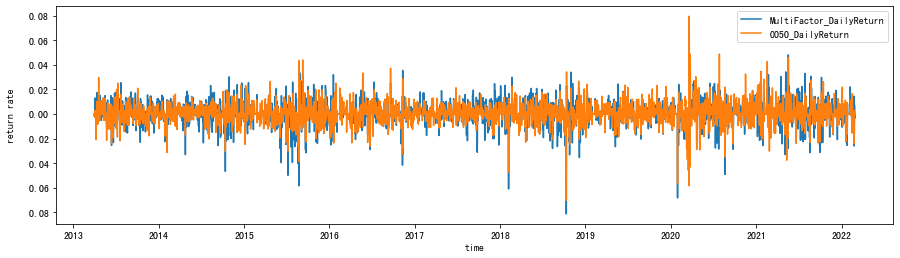

In [25]:
%matplotlib inline

fig = plt.figure(figsize=(15,4))
ax = plt.axes()
# ax.plot(return_df.columns, return_df.iloc[0, :], label='daily')
ax.plot(return_df.index, return_df.iloc[:, 0]-1, label='MultiFactor_DailyReturn')
# ax.plot(return_df.columns, return_df.iloc[1, :], label='0050_daily')
ax.plot(return_df.index, return_df.iloc[:, 1]-1, label='0050_DailyReturn')
ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('return rate')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

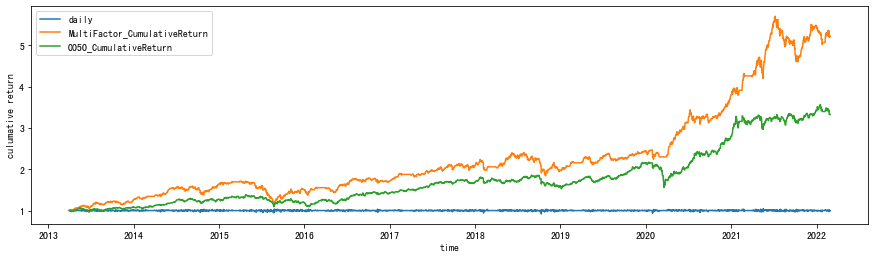

In [26]:
fig = plt.figure(figsize=(15,4))
ax = plt.axes()
ax.plot(return_df.index, return_df.iloc[:, 0], label='daily')
ax.plot(cumu_return.index, cumu_return.iloc[:, 0], label='MultiFactor_CumulativeReturn')
# ax.plot(return_df.columns, return_df.iloc[1, :], label='0050_daily')
ax.plot(cumu_return.index, cumu_return.iloc[:, 1], label='0050_CumulativeReturn')
ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('culumative return')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

# 指標：年化報酬IRR 波動度 max drawdown、 sharpe ratio、 sortino ratio

In [27]:
MultiFactor_Performance = {}
Fifty_Performance = {}

### IRR

In [28]:
MultiFactor_Performance['IRR'] = cumu_return.iloc[-1, 0]**(1/9) - 1
Fifty_Performance['IRR'] = cumu_return.iloc[-1, 1]**(1/9) - 1

### Volality

In [29]:
return_df.MultiFactor_Portfolio>0

2013-03-31    True
2013-04-01    True
2013-04-02    True
2013-04-03    True
2013-04-04    True
              ... 
2022-02-24    True
2022-02-25    True
2022-02-26    True
2022-02-27    True
2022-02-28    True
Name: MultiFactor_Portfolio, Length: 3257, dtype: bool

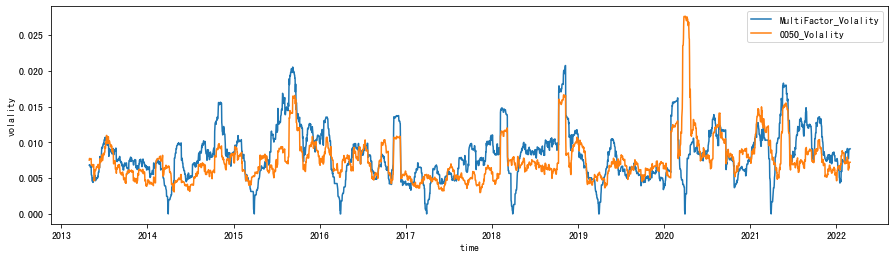

In [30]:
volality_df = copy.copy(return_df)
volality_df['MultiFactor_Portfolio'] = volality_df['MultiFactor_Portfolio'].rolling(30).apply(lambda x : x.std())
volality_df['0050'] = volality_df['0050'].rolling(30).apply(lambda x : x.std())

fig = plt.figure(figsize=(15,4))
ax = plt.axes()
# ax.plot(return_df.columns, return_df.iloc[0, :], label='daily')
ax.plot(volality_df.index, volality_df.iloc[:, 0], label='MultiFactor_Volality')
# ax.plot(return_df.columns, return_df.iloc[1, :], label='0050_daily')
ax.plot(volality_df.index, volality_df.iloc[:, 1], label='0050_Volality')
ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('volality')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

### Sharpe Ratio

In [31]:
MultiFactor_Performance['SharpeRatio'] = np.mean(return_df.iloc[:, 0]-1) / np.std(return_df.iloc[:, 0]-1)
Fifty_Performance['SharpeRatio'] = np.mean(return_df.iloc[:, 1]-1) / np.std(return_df.iloc[:, 1]-1)

### Sortino Ratio

In [32]:
np.mean(return_df.iloc[:, 0]-1) / np.std(return_df.loc[return_df.MultiFactor_Portfolio > 1, 'MultiFactor_Portfolio']-1)

0.08221963442181436

In [33]:
return_df.MultiFactor_Portfolio>0

2013-03-31    True
2013-04-01    True
2013-04-02    True
2013-04-03    True
2013-04-04    True
              ... 
2022-02-24    True
2022-02-25    True
2022-02-26    True
2022-02-27    True
2022-02-28    True
Name: MultiFactor_Portfolio, Length: 3257, dtype: bool

In [34]:
MultiFactor_Performance['SortinoRatio'] = np.mean(return_df.iloc[:, 0]-1) / np.std(return_df.loc[return_df['MultiFactor_Portfolio'] > 1, 'MultiFactor_Portfolio']-1)
Fifty_Performance['SortinoRatio'] = np.mean(return_df.iloc[:, 1]-1) / np.std(return_df.loc[return_df['0050'] > 1, '0050']-1)

In [35]:
MultiFactor_Performance

{'IRR': 0.20158689477665348,
 'SharpeRatio': 0.06126379243294166,
 'SortinoRatio': 0.08221963442181436}

In [36]:
Fifty_Performance

{'IRR': 0.14288979378583466,
 'SharpeRatio': 0.0495936749963751,
 'SortinoRatio': 0.05889314721397064}